In [1]:
!pip install pyod tensorflow scikit-learn matplotlib seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.6/200.6 kB 5.8 MB/s eta 0:00:00


In [12]:
# =============================
# Install dependencies in Colab
# =============================
# Uncomment if running in Colab
# !pip install pyod tensorflow scikit-learn matplotlib seaborn

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Optional
from sklearn.preprocessing import StandardScaler
from pyod.models.ecod import ECOD
from pyod.models.copod import COPOD
from pyod.models.iforest import IForest

import tensorflow as tf
from keras import layers, models


# =============================
# Data Preprocessing
# =============================

class DataProcessor:
    """Handles CSV loading, cleaning, and validation for time series data."""

    def __init__(self, min_hours: int = 72):
        self.min_hours = min_hours
        self.scaler: Optional[StandardScaler] = None

    def load_and_clean(self, csv_path: str) -> pd.DataFrame:
        """Load, clean and validate CSV."""
        df = pd.read_csv(csv_path)

        if "Time" not in df.columns:
            raise ValueError("❌ Input CSV must contain a 'Time' column.")

        df["Time"] = pd.to_datetime(df["Time"], errors="coerce")
        df = df.dropna(subset=["Time"])
        df = df.sort_values("Time").reset_index(drop=True)

        # Check for minimum length
        if len(df) < self.min_hours:
            raise ValueError(
                f"❌ Dataset too short. Need at least {self.min_hours} rows (hours)."
            )

        # Handle missing values
        df = df.interpolate(method="linear").fillna(method="bfill").fillna(method="ffill")

        # Remove constant features
        df = df.loc[:, df.nunique() > 1]

        # Warn if irregular intervals
        diffs = df["Time"].diff().dropna()
        if diffs.std() > pd.Timedelta("1s"):
            print("⚠ Warning: Irregular time intervals detected. Consider resampling.")

        return df

    def scale(self, df: pd.DataFrame, exclude: List[str] = ["Time"]) -> pd.DataFrame:
        """Scale numerical features with StandardScaler."""
        features = [c for c in df.columns if c not in exclude]
        self.scaler = StandardScaler()
        df_scaled = df.copy()
        df_scaled[features] = self.scaler.fit_transform(df[features])
        return df_scaled


# =============================
# LSTM Autoencoder Model
# =============================

class LSTMAutoencoder:
    """Telemanom-style LSTM Autoencoder for anomaly detection."""

    def __init__(self, timesteps: int = 24, latent_dim: int = 16):
        self.timesteps = timesteps
        self.latent_dim = latent_dim
        self.model: Optional[models.Model] = None

    def build(self, n_features: int) -> models.Model:
        """Build LSTM Autoencoder."""
        inputs = layers.Input(shape=(self.timesteps, n_features))
        encoded = layers.LSTM(self.latent_dim, activation="tanh", return_sequences=False)(inputs)
        repeat = layers.RepeatVector(self.timesteps)(encoded)
        decoded = layers.LSTM(n_features, activation="linear", return_sequences=True)(repeat)
        self.model = models.Model(inputs, decoded)
        self.model.compile(optimizer="adam", loss="mse")
        return self.model

    def fit(self, X_train: np.ndarray, epochs: int = 20, batch_size: int = 32) -> None:
        """Train autoencoder."""
        self.model.fit(
            X_train, X_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=0.1,
            shuffle=False,
            verbose=1
        )

    def reconstruct(self, X: np.ndarray) -> np.ndarray:
        """Reconstruct sequences with the trained model."""
        return self.model.predict(X, verbose=0)


# =============================
# Anomaly Detection Wrapper
# =============================

class AnomalyDetector:
    """Wrapper for LSTM Autoencoder + PyOD ensemble methods."""

    def __init__(self, lstm_model: LSTMAutoencoder,
                 pyod_models=None,
                 weights=None):
        self.lstm_model = lstm_model
        self.pyod_models = pyod_models if pyod_models else []
        self.weights = weights if weights else [0.5, 0.2, 0.15, 0.15]  # LSTM, IForest, ECOD, COPOD

    def get_windows(self, X: np.ndarray, timesteps: int) -> np.ndarray:
        """Create rolling windows for sequence models."""
        return np.array([X[i:i+timesteps] for i in range(len(X)-timesteps)])

    def detect(self, df_scaled: pd.DataFrame,
               train_end: str, full_end: str) -> pd.DataFrame:
        """Run anomaly detection and return results DataFrame."""
        features = [c for c in df_scaled.columns if c != "Time"]

        # Train / Test Split
        train_df = df_scaled[df_scaled["Time"] <= train_end]
        test_df = df_scaled[df_scaled["Time"] <= full_end]

        X_train = train_df[features].values
        X_test = test_df[features].values

        # =============================
        # LSTM Autoencoder
        # =============================
        X_train_seq = self.get_windows(X_train, self.lstm_model.timesteps)
        X_test_seq = self.get_windows(X_test, self.lstm_model.timesteps)

        self.lstm_model.build(n_features=len(features))
        self.lstm_model.fit(X_train_seq)

        X_test_recon = self.lstm_model.reconstruct(X_test_seq)
        errors = np.mean((X_test_seq - X_test_recon) ** 2, axis=(1, 2))
        lstm_scores = 100 * (errors - errors.min()) / (errors.max() - errors.min() + 1e-8)

        # Feature attribution with >1% rule + tie-break alphabetically
        top_features = []
        last_errors = np.mean(np.abs(X_test_seq - X_test_recon), axis=1)

        for row in last_errors:
            contrib = row / (row.sum() + 1e-8)

            # Pair (feature, contribution) and filter >1%
            pairs = [(features[i], contrib[i]) for i in range(len(features)) if contrib[i] > 0.01]

            # Sort: first by contribution desc, then alphabetically
            pairs.sort(key=lambda x: (-x[1], x[0]))

            # Take top 7
            top = [f for f, _ in pairs[:7]]
            top += [""] * (7 - len(top))
            top_features.append(top)

        # =============================
        # PyOD Models
        # =============================
        pyod_scores_all = []
        for model in self.pyod_models:
            model.fit(X_train)
            pyod_scores = model.decision_function(X_test)
            pyod_scores = 100 * (pyod_scores - pyod_scores.min()) / (pyod_scores.max() - pyod_scores.min() + 1e-8)
            pyod_scores_all.append(pyod_scores)

        # Align lengths
        min_len = min([len(lstm_scores)] + [len(s) for s in pyod_scores_all])
        lstm_scores = lstm_scores[-min_len:]
        pyod_scores_all = [s[-min_len:] for s in pyod_scores_all]

        # =============================
        # Ensemble Scoring
        # =============================
        all_scores = [lstm_scores] + pyod_scores_all
        weights = self.weights[:len(all_scores)]
        final_scores = np.average(np.vstack(all_scores), axis=0, weights=weights)

        # Add small noise if scores collapse
        if np.allclose(final_scores, final_scores[0]):
            final_scores += np.random.normal(0, 0.5, size=len(final_scores))

        # =============================
        # Assemble Result
        # =============================
        result = test_df.iloc[-min_len:].copy()
        result["Abnormality_score"] = final_scores  # ✅ fixed name

        for i in range(7):
            result[f"top_feature_{i+1}"] = [tf[i] for tf in top_features[-min_len:]]

        # Static binning (spec compliant)
        def classify_static(score: float) -> str:
            if score <= 10: return "Normal"
            elif score <= 30: return "Slightly Unusual"
            elif score <= 60: return "Moderate"
            elif score <= 90: return "Significant"
            else: return "Severe"

        result["Anomaly_Level"] = result["Abnormality_score"].apply(classify_static)

        return result


# =============================
# Visualization (dynamic thresholds)
# =============================

def plot_results(df: pd.DataFrame, score_col: str = "Abnormality_score"):
    """Plot smoothed scores with dynamic thresholds and mark anomalies."""
    df["Smoothed_Score"] = df[score_col].rolling(window=5, center=True).mean()
    df["Smoothed_Score"].fillna(df["Smoothed_Score"].mean(), inplace=True)

    mean = df["Smoothed_Score"].mean()
    std = df["Smoothed_Score"].std()
    moderate_th = mean + 2 * std
    significant_th = mean + 3 * std
    severe_th = mean + 4 * std

    plt.figure(figsize=(14, 7))
    plt.plot(df["Time"], df["Smoothed_Score"], label="Smoothed Score", color="blue")

    # Threshold lines
    plt.axhline(moderate_th, color="yellow", linestyle="--", label="Moderate")
    plt.axhline(significant_th, color="orange", linestyle="--", label="Significant")
    plt.axhline(severe_th, color="red", linestyle="--", label="Severe")

    # ✅ Add anomaly markers (dots)
    moderate_points = df[df["Smoothed_Score"] > moderate_th]
    significant_points = df[df["Smoothed_Score"] > significant_th]
    severe_points = df[df["Smoothed_Score"] > severe_th]

    plt.scatter(moderate_points["Time"], moderate_points["Smoothed_Score"],
                color="yellow", s=40, label="Moderate Anomalies", alpha=0.7)
    plt.scatter(significant_points["Time"], significant_points["Smoothed_Score"],
                color="orange", s=50, label="Significant Anomalies", alpha=0.8)
    plt.scatter(severe_points["Time"], severe_points["Smoothed_Score"],
                color="red", s=60, label="Severe Anomalies", alpha=0.9)

    plt.legend()
    plt.title("Anomaly Detection (Ensemble + Dynamic Thresholds)")
    plt.xlabel("Time")
    plt.ylabel("Abnormality Score")
    plt.show(block=False)

    return df


# =============================
# Main Pipeline
# =============================

def run_pipeline(input_csv: str, output_csv: str,
                 train_end="2004-01-05 23:59:00",
                 full_end="2004-01-19 07:59:00") -> pd.DataFrame:
    """Main pipeline function for training and anomaly detection."""
    dp = DataProcessor()
    df = dp.load_and_clean(input_csv)
    df_scaled = dp.scale(df)

    lstm = LSTMAutoencoder()
    pyod_models = [IForest(), ECOD(), COPOD()]
    detector = AnomalyDetector(lstm, pyod_models)

    result = detector.detect(df_scaled, train_end, full_end)
    final = pd.merge(df, result, on="Time", how="right")

    final.to_csv(output_csv, index=False)
    print(f"✅ Results saved to {output_csv}")

    plot_results(final)
    return final





/tmp/ipython-input-135485592.py:51: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.interpolate(method="linear").fillna(method="bfill").fillna(method="ffill")


Epoch 1/20
202/202 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.2799 - val_loss: 0.2654
Epoch 2/20
202/202 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.2642 - val_loss: 0.2604
Epoch 3/20
202/202 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.2583 - val_loss: 0.2571
Epoch 4/20
202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.2550 - val_loss: 0.2550
Epoch 5/20
202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.2528 - val_loss: 0.2529
Epoch 6/20
202/202 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.2509 - val_loss: 0.2514
Epoch 7/20
202/202 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.2494 - val_loss: 0.2501
Epoch 8/20
202/202 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.2481 - val_loss: 0.2491
Epoch 9/20
202/202 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.2471 - val_loss: 0.2482
Epoch 10/20
202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.2462 - val_loss: 0.2474
Epoch 11/20
202/202 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.2454 - val_loss: 0.2465
Epoch 12/20
202/202 ━━━━━━━━━━━━━━━━━━━━ 

/tmp/ipython-input-135485592.py:226: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Smoothed_Score"].fillna(df["Smoothed_Score"].mean(), inplace=True)


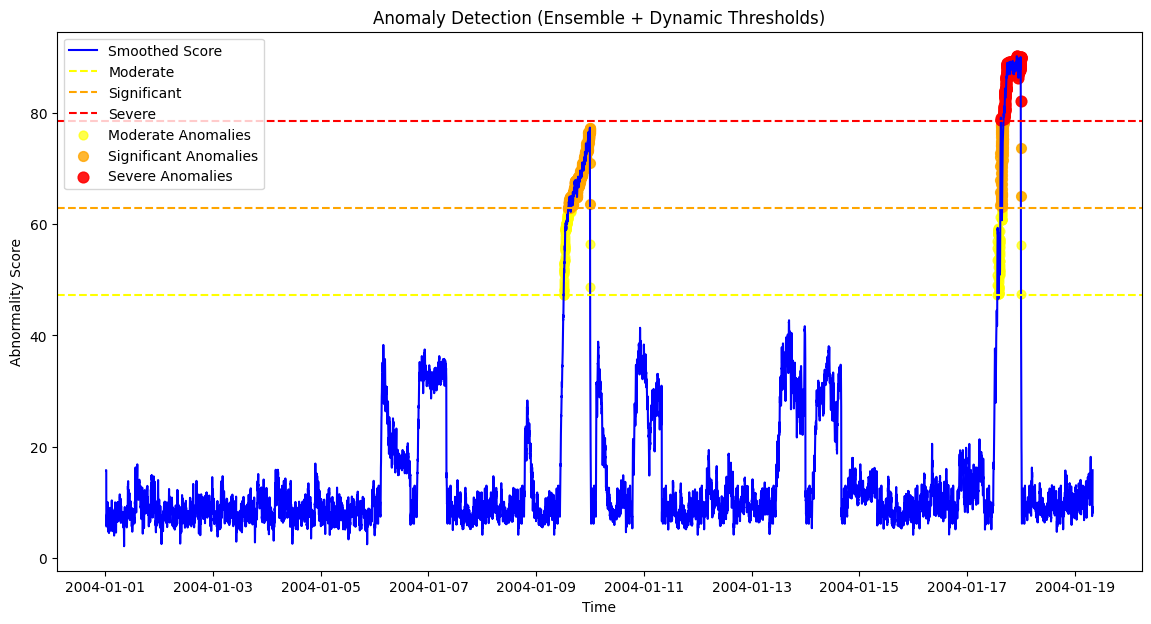

,Time,AFeedStream1_x,DFeedStream2_x,EFeedStream3_x,TotalFeedStream4_x,RecycleFlowStream8_x,ReactorFeedRateStream6_x,ReactorPressurekPagauge_x,ReactorLevel_x,ReactorTemperatureDegC_x,...,Abnormality_score,top_feature_1,top_feature_2,top_feature_3,top_feature_4,top_feature_5,top_feature_6,top_feature_7,Anomaly_Level,Smoothed_Score
0,2004-01-01 00:24:00,0.23392,3732.0,4481.1,9.3416,26.901,42.089,2700.5,75.605,120.42,...,5.677236,ProdSepUnderflowStream10,RecycleFlowStream8,ProductSepLevel,SeparatorPotLiquidFlowStream10,ComponentG11,ComponentD11,StripperLiquidProductFlowStream11,Normal,15.797650
1,2004-01-01 00:25:00,0.23546,3763.0,4542.1,9.3654,26.800,42.203,2700.0,74.491,120.41,...,7.580054,RecycleFlowStream8,ProdSepUnderflowStream10,ComponentG11,StripperUnderflowStream11,ReactorFeedRateStream6,ProductSepLevel,SeparatorPotLiquidFlowStream10,Normal,15.797650
2,2004-01-01 00:26:00,0.24973,3648.5,4534.8,9.2431,26.767,42.384,2697.8,74.593,120.42,...,5.383294,ProdSepUnderflowStream10,RecycleFlowStream8,ComponentG11,StripperUnderflowStream11,ProductSepLevel,SeparatorPotLiquidFlowStream10,ReactorFeedRateStream6,Normal,5.992638
3,2004-01-01 00:27:00,0.24790,3661.6,4519.6,9.2943,26.720,42.723,2699.5,73.918,120.39,...,5.628076,ProdSepUnderflowStream10,RecycleFlowStream8,ComponentG11,ProductSepLevel,SeparatorPotLiquidFlowStream10,StripperUnderflowStream11,ComponentH11,Normal,5.695293
4,2004-01-01 00:28:00,0.22171,3706.3,4479.5,9.3125,27.058,42.505,2696.8,75.807,120.41,...,5.694532,RecycleFlowStream8,ProdSepUnderflowStream10,ProductSepLevel,SeparatorPotLiquidFlowStream10,ComponentG11,ComponentH11,StripperUnderflowStream11,Normal,5.696974


In [13]:
# =============================
# Example usage in Colab
# =============================

input_path = "/content/input.csv"
output_path = "/content/output.csv"
df_final = run_pipeline(input_path, output_path)
df_final.head()

In [ ]:
# =============================
# Example usage in Colab
# =============================
# from google.colab import drive
# drive.mount('/content/drive')
#
# input_path = "/content/drive/MyDrive/input.csv"
# output_path = "/content/drive/MyDrive/output.csv"
# df_final = run_pipeline(input_path, output_path)
# df_final.head()


# =============================
# CLI usage (for local runs)
# =============================
# if __name__ == "__main__":
#     import argparse
#     parser = argparse.ArgumentParser(description="Run anomaly detection pipeline.")
#     parser.add_argument("--input", type=str, required=True, help="Path to input CSV file")
#     parser.add_argument("--output", type=str, required=True, help="Path to save output CSV")
#     parser.add_argument("--train_end", type=str, default="2004-01-05 23:59:00",
#                         help="End timestamp for training period")
#     parser.add_argument("--full_end", type=str, default="2004-01-19 07:59:00",
#                         help="End timestamp for full evaluation period")
#     args = parser.parse_args()
#
#     df_final = run_pipeline(args.input, args.output,
#                             train_end=args.train_end,
#                             full_end=args.full_end)
#     print(df_final.head())
